### RQ4: - Hypothesis testing for the presence or absence of Pareto Principle for the number of commits made by the software developers. Specifically, we will study if 80% of commit message come from 20% of committers for a random sample of 100,000 repositories (at each repository level).

In [1]:
import pandas as pd
import chardet
import nltk
from nltk.corpus import stopwords
import pickle
import pyarrow.parquet as pq
import numpy
import os
import vaex as vx
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
import math
import glob
from scipy.optimize import curve_fit
import time
from random import sample
from platform import python_version

#### Using VAEX dataframes for larger 

In [2]:
# VAEX DATAFRAME
df= []

In [3]:
# READ ALL THE PARQUET FILE
df = vx.open('/data/fdac21/eawoc//processed_data/*.parquet')

In [5]:
# COLUMN NAMES
columns = ["projectID", "commitID", "author", "committer", 
           "authorTime", "committerTime", "authorTimezone", 
           "committerTimezone", "commitMessage"]

In [6]:
# Review the data
df.head()

#,projectID,commitID,author,committer,authorTime,committerTime,authorTimezone,committerTimezone,commitMessage
0,wildfly_wildfly,00001a1a9d1552584eee5e62ab11d7b86408c0d8,ochaloup <ochaloup@redhat.com>,ochaloup <ochaloup@redhat.com>,1488898509,1489149067,+0100,+0100,'[JBTM-2858] adding JAXRS filter to import trans...
1,wildfly_wildfly,00010938ae7227834e2c69a9c3c71c95d3f3483d,Stuart Douglas <stuart.w.douglas@gmail.com>,Stuart Douglas <stuart.w.douglas@gmail.com>,1458105079,1458105079,+1100,+1100,WFCORE-1436 Undertow 1.3.19.Final
2,wildfly_wildfly,000183c08f9e7d9770ad8216acb565552da7bfb0,Jeff Mesnil <jmesnil@gmail.com>,Jeff Mesnil <jmesnil@gmail.com>,1332344580,1332436142,+0100,+0100,'[JBPAPP-8184] Connection factory failure\\n* add...
3,wildfly_wildfly,0001a3f7a195b75e563280609636faa249877036,jaikiran <jaikiran.pai@gmail.com>,baranowb <baranowb@gmail.com>,1328294482,1328611298,+0530,+0100,Upgrade to 2.0.0 of jboss-ejb3-ext-api
4,wildfly_wildfly,00024ccfa6fa6fd6426de7bb1d8d494798b384fe,James R. Perkins <jperkins@redhat.com>,GitHub <noreply@github.com>,1583899415,1583899415,-0700,-0700,'Merge pull request #13102 from kabir/WFLY-13222...
5,wildfly_wildfly,0002dbdc7b6cb98e6387cc5f0d11bb93229c5381,Kabir Khan <kkhan@redhat.com>,GitHub <noreply@github.com>,1491037874,1491037874,+0100,+0100,'Merge pull request #9883 from jbosstm/WFLY-8485...
6,wildfly_wildfly,000325d9bb03ceffbe9e7b4756a5566b273040d1,Brian Stansberry <brian.stansberry@redhat.com>,Brian Stansberry <brian.stansberry@redhat.com>,1503172204,1505862581,-0500,-0500,Minor cleanup
7,wildfly_wildfly,0003c4792f52061661cc9db421c7741bc4df8284,Richard Achmatowicz <rachmatowicz@jboss.com>,Paul Ferraro <paul.ferraro@redhat.com>,1370975878,1374591017,-0400,-0400,"[WFLY-1430] Add in XML processing, test cases."
8,wildfly_wildfly,0004ba7ca70b15a48fe6460ec5375c86cd8dc19d,Scott Marlow <smarlow@redhat.com>,Scott Marlow <smarlow@redhat.com>,1463689533,1473273893,-0400,-0400,'add org.wildfly.extension.nosql.common dependen...
9,wildfly_wildfly,000703aae4a2cc2cc0f1c4a9a03ae391bb76def0,Pelisse Romain <belaran@redhat.com>,GitHub <noreply@github.com>,1470623929,1470623929,+0000,+0000,'Merge 03a1e02b4aa392ec3d8914846eee615232f45d89 ...


In [7]:
# Generate value count for project name and number of commits made in it. (takes time)
px = pd.DataFrame(df.projectID.value_counts())

In [8]:
# assign the elements
proj_commits=px[0]
print(proj_commits.values)

[31332118 16770463  9960000 ...        2        2        2]


In [9]:
proj_commits.to_csv('RQ4-aggregate.csv')

Text(0, 0.5, '# of commits')

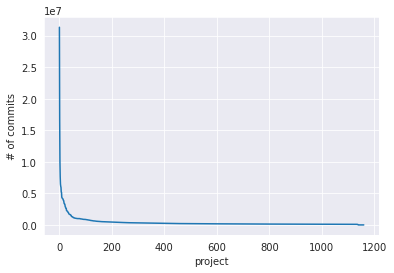

In [8]:
# some exploratory statistics. plot all the committ messages per project

sns.set_style('darkgrid')
p=sns.lineplot(data=proj_commits.values)
p.set_xlabel('project')
p.set_ylabel('# of commits')

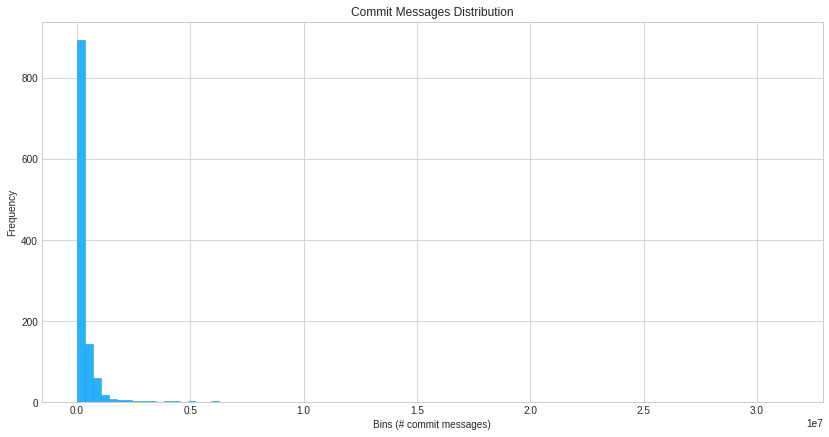

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


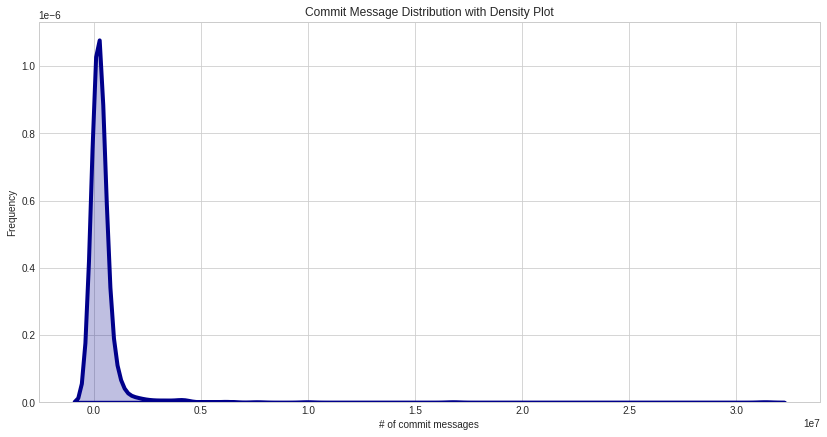

In [21]:
# HISTOGRAM, DENSITY PLOT, ETC OF ALL THE MESSAE COMBINED. 

plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(proj_commits.values, bins=90, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Commit Messages Distribution') 
plt.xlabel('Bins (# commit messages)') 
plt.ylabel('Frequency') 
plt.show()

plt.figure(figsize=(14,7)) # Make it 14x7 inch

sns.distplot(proj_commits.values, hist=False, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4, 'shade': True})
plt.legend()
plt.xlabel('# of commit messages')
plt.ylabel('Frequency')
plt.title('Commit Message Distribution with Density Plot')

#fig = plt.figure(figsize=(10,7))
#plt.boxplot(proj_commits.values)
#plt.savefig('ao.png')
plt.show()


#### SELECT RANDOM 1000 PROJECT AND PERFORM DESCRIPTIVE STATS AND DISPERSION

### [4] Hypothesis testing for the presence or absence of Pareto Principle for the number of commits made by the software developers. Specifically, we will study if 80% of commit message come from 20% of committers for a random sample of 100,000 repositories (at each repository level).

Calculating best minimal value for power law fit
2.163448638397054%
-0.7139325114870143 , 0.48887106277732084


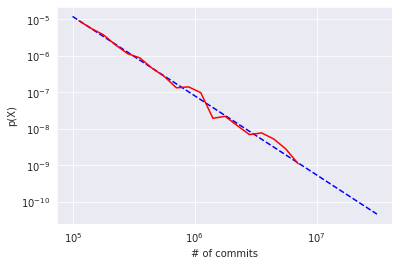

In [9]:
# We start by evaluating if the number of commits 
# in the list of project fit pareto distribution (power law distribution)
# below is the aggregate analysis of all the commits grouped by project id. 

import powerlaw
data = proj_commits.values # data can be list or numpy array
results = powerlaw.Fit(data)
print(results.power_law.alpha)
#print(results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'lognormal')
print (R, ',', p)
results.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
figPDF = results.plot_pdf( color= 'r', )
figPDF.set_xlabel("# of commits")
figPDF.set_ylabel("p(X)")

figPDF.figure.savefig('powerlaw-agg.png')


In [11]:
results.power_law.D

0.013967351361453773

#### Next, we will select a random 1000 projects and examine their distibution fitting to follow pareto principle. 

In [10]:
# list of project names 
project_names = df.projectID.unique()
print(project_names)

['saqib-ali_hivemined', 'git.kernel.org_pub_scm/public-inbox/vger.kernel.org/linux-media/0', 'RIOT-OS_RIOT', 'trattkantarell_src', 'sahil28297_erpnext', 'ThePiGuy0_android_device_motorola_msm8226-common', 'git.kernel.org_pub_scm/public-inbox/vger.kernel.org/lkml/0', 'jdzs1_b', 'ZIDAN44_linux-stable', 'Leaflet_Leaflet', 'timhuynh94_231AS', 'gitorious.org_netbeans/main-silver', 'discourse_discourse', 'nanoframework_ChibiOS-bkp', 'AnnaLut_abs3', 'civicrm_civicrm-core', 'thomasNDS_lbl', 'gentoo_gentoo', 'neo4j_neo4j', 'maritimerabroad_gitfiti', 'dotnet_aspnetcore', 'geos4s_18S856162', 'learn-co-curriculum_python-for-loops-lab', 'jthub_ega-file-transfer-to-collab-1-jtracker', 'denis-gz_qtbase', 'Alsan_turing-chunk07', 'CRAZYFAKE_handiwork', 'i17c_ecode', 'Reese-D_my_emacs', 'gitlab.com_Ponce_slackbuilds', 'jthub_ega-file-transfer-to-collab-2-jtracker', 'stoupoun_p2-breathe', 'Waffiliate_repoForSynch', 'jthub_ega-file-transfer-to-collab-5-jtracker', 'Arshiamidos_84ck1N617', 'mono_mono', 'app

In [12]:
project_samples = sample(project_names, 30)

allresults=[]
counter = 1

for project_sample in project_samples:
    try:      
        
        print("Calculating pareto analysis for: [",counter,'] ', project_sample)
        counter = counter + 1
        proj = df[df['projectID'] == project_sample]
        #proj.head()
        # GET COMMITER COUNT DISTRIBIUTION
        pp=proj['committer'].value_counts()
        print("Commiter distribution:", pp.values)
        #plt.plot(pp.values)
        data = pp.values # data can be list or numpy array
        results = powerlaw.Fit(data)
        
        R, p = results.distribution_compare('power_law', 'exponential')
        print ("R:", R, "P:", p)
        print('alpha:', results.power_law.alpha)
        if (results.power_law.alpha >= 2):
            print("Power law proof: True")
        print('sigma:', results.power_law.sigma)
        print(results.distribution_compare('power_law', 'exponential'))
        print("in-range:",results.power_law.in_range())
        allresults.append(results)
        continue
        results.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
        figPDF = results.plot_pdf( color= 'r', )
        figPDF.set_xlabel("# of commits")
        figPDF.set_ylabel("p(X)")
    except:
        print("some error")            

Calculating pareto analysis for: [ 1 ]  openresty_lua-nginx-module
Commiter distribution: [90599  7896  7600 ...     1     1     1]
Calculating best minimal value for power law fit
R: 1685.5075192659185 P: 3.990468760372117e-06
alpha: 1.758166838661905
sigma: 0.030823865264257
(1685.5075192659185, 3.990468760372117e-06)
in-range: True
Calculating pareto analysis for: [ 2 ]  influxdata_telegraf
Commiter distribution: [16099  6120  4707 ...     1     1     1]
Calculating best minimal value for power law fit
R: 372.187298519811 P: 1.9647066289439744e-05
alpha: 1.9075546238658543
sigma: 0.041597697983441616
(372.187298519811, 1.9647066289439744e-05)
in-range: True
Calculating pareto analysis for: [ 3 ]  fuel_core
Commiter distribution: [55200  7216  6027 ...     1     1     1]
Calculating best minimal value for power law fit
R: 168.82733736898712 P: 0.02063995244130129
alpha: 1.921969521933259
sigma: 0.06585496585237564
(168.82733736898712, 0.02063995244130129)
in-range: True
Calculating p

Commiter distribution: [351319      1]
Calculating best minimal value for power law fit
R: 7.675333042243258 P: 0.3953025346037701
alpha: 1.156623817962113
sigma: 0.11074976377633756
(7.675333042243258, 0.3953025346037701)
in-range: True
Calculating pareto analysis for: [ 7 ]  firemodels_fds
Commiter distribution: [97555 30901 26319 12963 11562  9534  7939  4132  3903  2982  2353  1986
  1888  1693  1693  1527  1225  1104  1037   910   900   879   876   752
   671   632   584   574   556   520   447   427   374   325   279   274
   264   253   248   240   236   232   208   196   188   166   166   128
   120   115   112   100    98    94    89    87    84    74    69    64
    60    60    60    50    50    45    41    40    39    36    34    33
    31    26    25    25    24    23    23    22    21    20    17    17
    17    17    16    16    12    11    11    10    10    10    10     9
     9     9     8     8     8     8     8     8     8     8     7     7
     6     6     5     5   

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
/home/amalviya/.local/lib/python3.8/site-packages/powerlaw.py:1151: RuntimeWarning: invalid value encountered in double_scalars
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
/home/amalviya/.local/lib/python3.8/site-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in double_scalars
  return 1 + len(data)/sum(log(data / (self.xmin)))
Not enough data. Returning nan
Not enough data. Returning nan
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No valid fits found.
Not enough data. Returning nan


R: 0 P: 1
alpha: nan
sigma: nan
(0, 1)
in-range: False
Calculating pareto analysis for: [ 13 ]  ThePiGuy0_android_device_motorola_msm8226-common
Commiter distribution: [82707  9828  4836 ...     1     1     1]
Calculating best minimal value for power law fit
R: 274.8407180310553 P: 0.03631063383085336
alpha: 2.01117991385489
Power law proof: True
sigma: 0.05524666041594887
(274.8407180310553, 0.03631063383085336)
in-range: True
Calculating pareto analysis for: [ 14 ]  git.kernel.org_pub_scm/public-inbox/lists.ozlabs.org/linuxppc-dev/0
Commiter distribution: [236210]
Calculating best minimal value for power law fit
R: 0 P: 1
alpha: nan
sigma: nan
(0, 1)
in-range: False
Calculating pareto analysis for: [ 15 ]  surli_backup-experiments


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan


Commiter distribution: [32461 23585 19670 ...     1     1     1]
Calculating best minimal value for power law fit
R: 8251.660874911702 P: 6.501564846366724e-45
alpha: 1.690542679701918
sigma: 0.009263398075585832
(8251.660874911702, 6.501564846366724e-45)
in-range: True
Calculating pareto analysis for: [ 16 ]  vt-alt_specs
Commiter distribution: [96984  5489  1697  1574  1276  1113  1109  1001   908   861   764   610
   591   547   528   457   443   436   367   363   329   326   311   256
   251   246   227   188   182   156   147   146   136   135   129   126
   116   116   114    97    92    88    87    81    77    67    66    66
    65    63    61    59    54    53    53    47    44    42    40    39
    37    35    34    34    34    30    30    28    28    27    25    24
    23    21    19    18    18    18    17    15    14    14    14    14
    13    13    12    11    11    11    10    10     9     8     7     7
     6     6     6     6     6     6     5     5     5     5     5  

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan


Commiter distribution: [10231  8972  5882  5438  5347  5338  4497  4384  4114  4002  3503  3334
  2859  2839  2835  2820  2701  2622  2396  2291  2035  1928  1851  1802
  1767  1620  1493  1379  1368  1366  1329  1266  1059  1023   906   875
   875   863   854   846   839   817   792   751   751   727   702   679
   618   617   602   589   558   555   526   473   465   410   406   398
   377   376   375   362   310   302   296   249   248   240   239   233
   188   177   175   174   173   168   166   164   158   140   136   135
   120   117   112   101    91    90    89    89    89    86    85    78
    76    75    75    73    71    67    64    52    51    49    49    49
    47    45    42    42    39    38    37    36    36    35    34    33
    33    31    29    28    27    25    24    24    23    23    21    19
    17    17    17    17    16    16    16    15    15    13    13    12
    12    12    11    11    10    10     9     9     9     8     8     7
     7     6     6     5    

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
No valid fits found.
Not enough data. Returning nan


Commiter distribution: [533781  28775  21972 ...      1      1      1]
Calculating best minimal value for power law fit
R: 1984.1552072593952 P: 0.00101967229467419
alpha: 1.6981198693029638
sigma: 0.018487161534313037
(1984.1552072593952, 0.00101967229467419)
in-range: True
Calculating pareto analysis for: [ 24 ]  pombredanne_sf.net-brlcad
Commiter distribution: [66273 59407 41483 13430 13250 11595  9920  8900  8266  7890  6060  5860
  4437  3766  3008  2771  2724  2249  2231  1817  1654  1205  1097  1055
   908   900   884   876   818   812   783   783   769   743   732   701
   665   663   544   511   476   472   442   431   396   345   336   297
   283   276   270   264   228   212   210   200   196   184   180   168
   165   152   152   128   126   124   115    79    76    67    64    60
    60    48    40    40    39    36    36    36    28    28    28    24
    21    20    20    20    16    16    15    15    12    12    10     8
     6     4     4     4     4     4     4     2  

Commiter distribution: [99867 27843  8628  7098  5830  4971  4268  2688  2518  2116  2091  2024
  1948  1930  1763  1312  1183  1158   989   955   922   828   756   650
   628   572   558   549   535   534   522   495   469   455   424   424
   414   358   352   347   339   315   258   238   234   225   215   202
   187   184   183   169   167   161   156   155   145   143   141   141
   140   130   123   122   121   121   118   112   111   109   107   103
    97    87    84    84    81    80    75    74    71    70    66    63
    63    60    54    52    51    46    45    45    44    44    43    42
    41    39    38    37    36    34    32    32    31    26    23    23
    22    21    21    21    21    19    19    18    17    15    15    14
    13    12    12    11    11    10    10     8     8     8     7     7
     7     6     6     6     6     6     6     6     6     5     5     4
     4     4     4     4     4     3     3     3     3     3     3     3
     3     2     2     2    

### [5.4] Develop static and interactive visualizations to demonstrate the findings.

In [15]:
l=[]
for a in allresults:
    if(a.power_law.alpha>0):
        print(a.power_law.alpha)
        l.append(a.power_law.alpha)

1.758166838661905
1.9075546238658543
1.921969521933259
1.831072338780022
2.1269354082016703
1.156623817962113
1.6793028428803285
1.465104949963853
1.680216305826625
1.5887978015338597
1.2109693431620183
2.01117991385489
1.690542679701918
1.9600549589397471
1.218832061840205
2.8078670272501736
1.3178880500192438
1.9227534881868373
1.6981198693029638
1.6437658795053351
3.9375877716765375
2.85766855144904
1.2932668874014468
1.7220560207306903
1.742009877562054
1.16062276319676


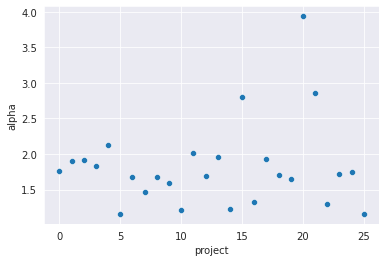

In [21]:
# some exploratory statistics. plot all the committ messages per project

sns.set_style('darkgrid')
p=sns.scatterplot(data=l)
p.set_xlabel('project')
p.set_ylabel('alpha')
plt.savefig('powerlaw-dis.png')